In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit,GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, confusion_matrix

import scipy

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, itertools, gc
from tqdm import tqdm

import category_encoders

# utils

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def show_confusion_matrix(cm, classes, normalize=False, cmap=plt.get_cmap('RdBu')):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    return 'auc', fast_auc(y_true, y_pred), True


# train func

In [3]:
def get_oof(clf,params, X, y, X_test,
                cv_scheme='kf', n_splits=5, shuffle=False, seed=42, groups=None,
                metrics=None, n_estimators=1000,
                verbose=200, early_stopping_rounds=100,
                conf_matrix=False, conf_matrix_norm=False,
               encoder=None, encode_cols=None,
               train_cols=None, show_importance=True):
    if metrics is None:
        metrics = [('f1', f1_score)]
    if cv_scheme is 'kf':
        cv_split = KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    elif cv_scheme is 'skf':
        cv_split = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
    elif cv_scheme is 'ts':
        cv_split = TimeSeriesSplit(n_splits=n_splits)
    elif cv_scheme is 'gkf':
        cv_split = GroupKFold(n_splits=n_splits)

    S_train = np.zeros((X.shape[0],))
    S_test = np.zeros((X_test.shape[0],))

    if conf_matrix:
        cms = []
    scores = pd.DataFrame()
    feature_importance = pd.DataFrame()
    for metric_name, metric in metrics:
        scores[metric_name] = np.ndarray((n_splits,))
    
    if cv_scheme is 'gkf':
        splits = cv_split.split(X, y, groups)
    else:
        splits = cv_split.split(X, y)
    for fold_n, (tr_idx, val_idx) in enumerate(splits):
        
        if type(X) is np.ndarray:
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
        elif type(X) is scipy.sparse.csr.csr_matrix:
            X_tr, X_val = X[tr_idx], X[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
        else:
            if train_cols is None:
                train_cols = list(X.columns)
            X_tr, X_val = X[train_cols].iloc[tr_idx], X[train_cols].iloc[val_idx]
            y_tr, y_val = y[tr_idx], y[val_idx]
            
        
        X_t = X_test.copy()
        if encoder:
            if encode_cols is None:
                encode_cols = list(X.columns)
            encoder_double = DoubleValidationEncoderNumerical(cols=encode_cols, encoder=encoder, folds=cv_split)
            X_tr = encoder_double.fit_transform(X_tr, y_tr)
            X_val = encoder_double.transform(X_val)
            X_t = encoder_double.transform(X_t)
        
        if clf is 'lgb':
            model = LGBMClassifier(**params,
                                       n_estimators=n_estimators,
                                       n_jobs=-1)
            model.fit(X_tr, y_tr,
                      eval_set=[(X_tr, y_tr), (X_val, y_val)],
                      eval_metric=eval_auc,
                      verbose_eval=verbose,
                      early_stopping_rounds=early_stopping_rounds)
            
            oof_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(X_t,
                                            num_iteration=model.best_iteration_)[:, 1]

            
        if clf is 'cat':
            model = CatBoostClassifier(**params,
                                          n_estimators=n_estimators)
            
            model.fit(X_tr, y_tr,
                      eval_set=(X_val, y_val),
                      verbose_eval=verbose,
                      early_stopping_rounds=early_stopping_rounds)
        
            oof_pred = model.predict_proba(X_val)[:,1]
            test_pred = model.predict_proba(X_t)[:,1]
        
        if clf is 'logreg':
            model = LogisticRegression(**params)
            model.fit(X_tr, y_tr)
            oof_pred = model.predict_proba(X_val)[:,1]
            test_pred = model.predict_proba(X_t)[:,1]
        
        if metrics:
            for (metric_name, metric) in metrics:
                scores.loc[fold_n, metric_name] = metric(y_val, oof_pred)

        S_train[val_idx] = oof_pred.ravel()
        S_test += test_pred

        if conf_matrix:
            cms.append(confusion_matrix(y_val, for_metrics))
        
        if show_importance:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = train_cols
            if clf is 'logreg':
                fold_importance["importance"] = model.coef_[0]
            else:
                fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    S_test /= n_splits
    
    if show_importance:
        feature_importance["importance"] /= n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index
        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
        plt.figure(figsize=(16, 12))
        sns.barplot(x="importance",
                    y="feature",
                    data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LGB Features (avg over folds)')

    if conf_matrix:
        cm = np.average(cms, axis=0)
        plt.figure()
        show_confusion_matrix(cm=cm, classes=[0, 1], normalize=conf_matrix_norm)

    print('=' * 60)
    if metrics is not None:
        for metric in scores.columns:
            print(f'[{metric}]\t', 'CV mean:', np.mean(scores[metric]), ', std:', np.std(scores[metric]))
    return S_train.reshape(-1, 1), S_test.reshape(-1, 1).ravel()

# fe

In [4]:
class DoubleValidationEncoderNumerical:
    def __init__(self, cols, encoder, folds):
        self.cols = cols
        self.encoder = encoder
        self.encoders_dict = {}
        self.folds = folds

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        for n_fold, (train_idx, val_idx) in enumerate(self.folds.split(X, y)):
            X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
            y_train, y_val = y[train_idx], y[val_idx]
            _ = self.encoder.fit_transform(X_train[self.cols], y_train)
            
            val_t = self.encoder.transform(X_val)
            val_t = val_t.fillna(np.mean(y_train))
            if n_fold == 0:
                cols_representation = np.zeros((X.shape[0], val_t.shape[1]))
            
            self.encoders_dict[n_fold] = self.encoder
            cols_representation[val_idx, :] += val_t.values
        cols_representation = pd.DataFrame(cols_representation, columns=X.columns)
        return cols_representation

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.reset_index(drop=True)
        cols_representation = None
        for encoder in self.encoders_dict.values():
            test_tr = encoder.transform(X)

            if cols_representation is None:
                cols_representation = np.zeros(test_tr.shape)
            cols_representation = cols_representation + test_tr / self.folds.n_splits
        cols_representation = pd.DataFrame(cols_representation, columns=X.columns)
        return cols_representation
    
def process_data(data: pd.DataFrame):
    data['ord_5_1'] = data['ord_5'].apply(lambda x: x[0])
    data['ord_5_2'] = data['ord_5'].apply(lambda x: x[1])

    mapper_ord_1 = {'Novice': 1, 
                'Contributor': 2,
                'Expert': 3, 
                'Master': 4, 
                'Grandmaster': 5}

    mapper_ord_2 = {'Freezing': 1, 
                    'Cold': 2, 
                    'Warm': 3, 
                    'Hot': 4,
                    'Boiling Hot': 5, 
                    'Lava Hot': 6}

    mapper_ord_3 = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 
                    'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15}

    mapper_ord_4 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 
                    'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
                    'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 
                    'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
    
    for col, mapper in zip(['ord_1', 'ord_2', 'ord_3', 'ord_4'], [mapper_ord_1, mapper_ord_2, mapper_ord_3, mapper_ord_4]):
        data[col] = data[col].replace(mapper)
        
    ord_5 = sorted(list(set(data['ord_5'].values)))
    ord_5 = dict(zip(ord_5, range(len(ord_5))))
    data.loc[:, 'ord_5'] = data['ord_5'].apply(lambda x: ord_5[x]).astype(float)
    
    data['bin_3'] = data['bin_3'].apply(lambda x: 1 if x == 'T' else 0)
    data['bin_4'] = data['bin_4'].apply(lambda x: 1 if x == 'Y' else 0)
    
    def date_cyc_enc(df, col, max_vals):
        df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
        df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
        return df

    data = date_cyc_enc(data, 'day', 7)
    data = date_cyc_enc(data, 'month', 12)
    
    return data

def do_le(X, X_test, cols):
    X_tr = pd.DataFrame()
    X_te = pd.DataFrame()
    new_cols = []
    for c in cols:
        c_name = c + '_le'
        new_cols.append(c_name)
        le = LabelEncoder()
        le.fit(list(X[c].astype(str).values) + list(X_test[c].astype(str).values))
        X_tr[c_name] = le.transform(list(X[c].astype(str).values))
        X_te[c_name] = le.transform(list(X_test[c].astype(str).values))
    return X_tr, X_te, new_cols

def do_ohe(X, X_test, cols):
    X_tr = pd.DataFrame()
    X_te = pd.DataFrame()
    new_cols = [c+'_ohe' for c in cols]
    X_tr = pd.get_dummies(X[cols])
    X_te = pd.get_dummies(X_test[cols])
    X_tr.columns = new_cols
    X_te.columns = new_cols
    return X_tr, X_te, new_cols

def do_hash(X, X_test, cols, preffix=None, n_feats=None):
    if preffix is None:
        raise ValueError('preffix should be set.')
    if n_feats is None:
        raise ValueError('n_feats should be set.')
    X_tr = pd.DataFrame()
    X_te = pd.DataFrame()
    new_cols = []
    
    for c in cols:
        c_name = c+'_hash'
        new_cols.append(c_name)
        size = X[c].nunique()
        X_tr[c_name] = X[c].apply( lambda x: hash(str(x)) % size )
        X_te[c_name] = X_test[c].apply( lambda x: hash(str(x)) % size )
    return X_tr, X_te, new_cols

def do_bin(X, X_test, cols):
    X_tr = pd.DataFrame()
    X_te = pd.DataFrame()
    be = category_encoders.BinaryEncoder(cols=cols).fit(X)
    X_tr = be.transform(X)
    X_te = be.transform(X_test)
    new_cols = list(X_tr.columns)
    return X_tr, X_te, new_cols

def do_freq(X, X_test, cols):
    X_tr = pd.DataFrame()
    X_te = pd.DataFrame()
    new_cols = []
    for c in cols:
        c_name = c+'_freq'
        new_cols.append(c_name)
        tmp = pd.concat([X[[c]], X_test[[c]]])
        enc = tmp[c].value_counts().to_dict()   
        X_tr[c_name] = X_tr[c].map(enc)
        X_te[c_name]  = X_te[c].map(enc)
    return X_tr, X_te, new_cols

In [5]:
gc.collect()

SEED = 42
set_seed(SEED)

path = '/kaggle/input/cat-in-the-dat/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sub = pd.read_csv(path+'sample_submission.csv')

In [6]:
lc_nom = [f'nom_{i}'for i in range(0,5)]
hc_nom = [f'nom_{i}'for i in range(5,10)]
lc_ord = [f'ord_{i}'for i in range(0,3)]
hc_ord = [f'ord_{i}'for i in range(3,6)]

In [7]:
train = process_data(train)
test = process_data(test)

In [8]:
# top_cols = ['ord_5_1', 'month', 'bin_1','nom_2','nom_4','nom_0']
# cat_cols = [c for c in train.columns if c not in ['id', 'target']]
# inter_cols= []
# for c1 in top_cols:
#     for c2 in tqdm(cat_cols):
#         if c1 != c2:
#             train[f'{c1}_{c2}'] = train[c1].astype(str) + '_' + train[c2].astype(str)
#             test[f'{c1}_{c2}'] = test[c1].astype(str) + '_' + test[c2].astype(str)
#             inter_cols.append(f'{c1}_{c2}')

In [9]:
X = train.drop(['target','id'],1)
y = train.target
X_test = test.drop('id',1)
test = test[['id']]

In [10]:
# traintest = pd.concat([X, X_test])
# dummies = pd.get_dummies(traintest, columns=traintest.columns, drop_first=True, sparse=True)

# X_ohe = dummies.iloc[:X.shape[0], :].sparse.to_coo().tocsr()
# X_test_ohe = dummies.iloc[X.shape[0]:, :].sparse.to_coo().tocsr()

In [11]:
# OHE for LOW cardinality NOMINAL and ORDINAL columns
for_ohe = list(lc_nom+lc_ord)
X_ohe, X_test_ohe, ohe_cols = do_ohe(X, X_test, for_ohe)
del X_ohe, X_test_ohe
gc.collect()

# HASHING for HIGH cardinality NOMINAL and ORDINAL columns
for_hash = []
for preffix,cols in zip([hc_nom,hc_ord],['nom_','ord_']):
    n_feats = X[cols].nunique().sum()
    X_hash, X_test_hash, hash_cols = do_hash(X,X_test,cols,preffix, n_feats=n_feats)
    X = pd.concat([X, X_hash],1).drop(cols,1,inplace=True)
    X_test = pd.concat([X_test, X_test_hash],1).drop(cols,1,inplace=True)
del X_hash, X_test_hash
gc.collect()

# BINARY ENCODER for HIGH cardinality ORDINAL columns
for_bin = []
X_bin, X_test_bin, bin_cols = do_bin(X, X_test, hc_ord)
del X_bin, X_test_bin
gc.collect()

# LABEL ENCODER for LOW cardinality ORDINAL columns
for_le = ['nom_9']
X_le, X_test_le, le_cols = do_le(X, X_test, for_le)
del X_le, X_test_le
gc.collect()

# FREQUENCY ENCODER
for_freq = []
X_freq, X_test_freq, freq_cols = do_freq(X, X_test, for_freq)
del X_freq, X_test_freq
gc.collect()

X = pd.concat([X, 
               X_bin,
               X_le,
               X_ohe,
               X_hash,
              ],1).drop(
    for_bin,
    for_le,
    for_ohe,
    for_hash
    ,1)
X_test = pd.concat([X_test, 
                    X_test_bin,
                    X_test_le,
                    X_test_ohe,
                    X_test_hash,
                   ],1).drop(
    for_bin,
    for_le,
    for_ohe,
    for_hash
    ,1)

In [12]:
cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'task_type': 'GPU',
    
    'od_wait':200,
    'metric_period':500,

    'learning_rate': 0.02,
#     'max_depth': 7,
#     'num_leaves':,
#     'colsample_bylevel'
}

logreg_params={
    'random_state': SEED,
    'solver': 'lbfgs',
    'n_jobs': -1,
    
    'class_weight':'balanced',
    'C': 0.1,
    'verbose': False,
}

In [13]:
metrics = [
    ('log', log_loss),
    ('auc', roc_auc_score)
]

In [14]:
obj_cols = list(X.columns)

[log]	 CV mean: 0.5449344714175799 , std: 0.002079853360591683
[auc]	 CV mean: 0.7983933477476269 , std: 0.0022540162156000523


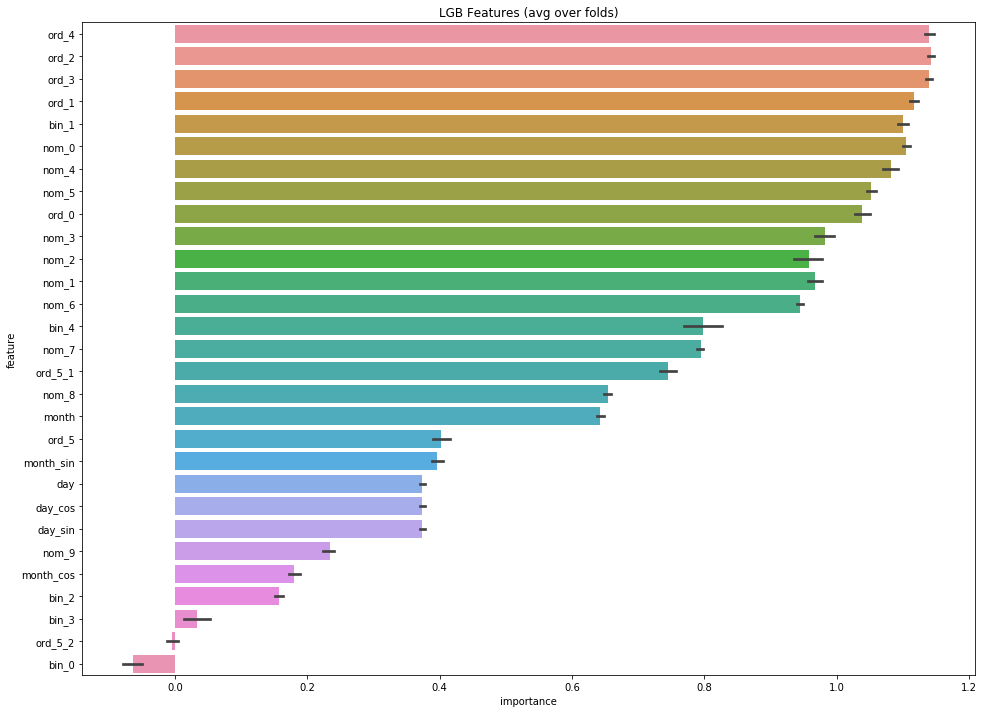

In [15]:
enc = category_encoders.CatBoostEncoder(cols=obj_cols)
S_oof_ohe, S_test_ohe = get_hue_oof(clf='logreg',params=logreg_params, 
                                    X=X, y=y, X_test=X_test,
                                    cv_scheme='skf', n_splits=5, shuffle=False, seed=SEED, 
                                    metrics=metrics, n_estimators=2000,
                                    verbose=500, early_stopping_rounds=100,
                                    conf_matrix=False,
                                    encoder=enc, encode_cols=obj_cols)

In [17]:
S_oof_cb, S_test_cb = get_hue_oof(clf='logreg',params=logreg_params, 
                                  X=X_ohe, y=y, X_test=X_test_ohe,
                                  cv_scheme='skf', n_splits=5, shuffle=False, seed=SEED, 
                                  metrics=metrics, n_estimators=2000,
                                  verbose=500, early_stopping_rounds=100,
                                  conf_matrix=False, show_importance=False)

[log]	 CV mean: 0.5353034034010715 , std: 0.003238851900277987
[auc]	 CV mean: 0.8033055111557198 , std: 0.0024759395288457557


In [18]:
test['pred'] = S_test_cb.ravel()
sub['target'] = pd.merge(sub, test, on='id')['pred']
sub.to_csv('lr_cb.csv', index=False)

In [19]:
test['pred'] = (S_test_cb.ravel() + S_test_ohe.ravel())/2
sub['target'] = pd.merge(sub, test, on='id')['pred']
sub.to_csv('blend.csv', index=False)